In [1]:
"""
updated 2019-08-07 
written by Minhae Kwon


- `recoding`: Estimate the next belief from current belief and observations
    - input:
        - if you use POMDP data (for now): `recoding_pomdp_all_prev_df.csv` and `recoding_pomdp_all_now_df.csv`
        - ideally with neural data: `recoding_neural_all_prev_df.csv` and `recoding_neural_all_now_df.csv`
    - output: `recoding_belief_results_df.csv` (estimated future belief)
    - method: Autoregression - this is linear regression between two time steps. 
    - there are two versions in codes:
        -`recoding_wo_RBF.ipynb`: no RBF is used. 
        - `recoding_KRR.ipynb`: RBF is used using sklearn built-in function: [Kernel Ridge Regression (kernel ='rbf')](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html). 
        (Warning: this code runs pretty slow compared to others. So if you need to handle big data size, plan in advance!)
        - `recoding_manualRBF.ipynb`: RBF is manually coded by me. So we can customize center locations for nonlinear transform. 
        Everything is the same as `recoding_wo_RBF.ipynb` but RBF.
        - `recoding_KRR.ipynb` works the best, and pretty good!
        
        
ref: https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression
https://scikit-learn.org/stable/auto_examples/plot_kernel_ridge_regression.html#sphx-glr-auto-examples-plot-kernel-ridge-regression-py


ref: https://chrisalbon.com/machine_learning/linear_regression/linear_regression_using_scikit-learn/
     https://datatofish.com/multiple-linear-regression-python/

cross validate score: Coefficient of determination
https://en.wikipedia.org/wiki/Coefficient_of_determination
"""

from pandas import DataFrame, read_csv
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import matplotlib.pyplot as plt

POMDP = True
TEST_SIZE = 0.2  # ratio of test data set 
N_SPLITS = 2 # "K" in K-fold cross validation 



### if you use pomdp data

In [2]:
if POMDP == True:
    bb_df_prev = read_csv('./data/recoding_pomdp_all_prev_df.csv')
    bb_df_now = read_csv('./data/recoding_pomdp_all_now_df.csv')
else: #neural data
    bb_df_prev = read_csv('./data/recoding_neural_all_prev_df.csv') 
    bb_df_now = read_csv('./data/recoding_neural_all_now_df.csv') 

In [3]:
X = bb_df_prev.to_numpy()#[:10000]
y = bb_df_now[['behavior_belief1', 'behavior_belief2']].to_numpy()#[:10000]

In [4]:
# make the same distance for all input data
X[:,:2] = X[:,:2]*10
y = y*10 

### there are 3 types of data: test data, train data, validation data

In [5]:

# separate test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state = 1)

In [6]:
#regr = LinearRegression() # linear regression is used for encoding process
regr = KernelRidge(alpha=0.01, gamma=0.1, kernel='rbf') # linear regression(small gamma) with RBF kernel


In [7]:
# now we use only train data 
# why use StratifiedKFold?: The folds are made by preserving the percentage of samples for each class.
k_fold = StratifiedKFold(n_splits=N_SPLITS) # seperate train data and validation data

In [8]:
# why argmax(1)? split cannot simply handle multidimension y. 
# ref: https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
for i, (train_index, val_index) in enumerate(k_fold.split(X_train, y_train.argmax(1))):
    x_train_kf, x_val_kf = X[train_index], X[val_index]
    y_train_kf, y_val_kf = y[train_index], y[val_index]
    regr.fit(x_train_kf, y_train_kf) # fit the model
    pred = regr.predict(x_val_kf) # predict based on current model -> use validation data for evaluation
    print('score', r2_score(y_val_kf, pred, multioutput='raw_values')) # get r2 score

score [0.62664329 0.6578819 ]
score [0.62644831 0.65996239]


In [9]:
# model parameter
print(regr.dual_coef_.shape)
print(regr.dual_coef_)

(39920, 2)
[[  63.66918587  192.80230076]
 [ 251.84908811  -76.74877782]
 [-146.71901075    4.2924449 ]
 ...
 [ 321.65547404   47.90438662]
 [-280.53872293   73.61854988]
 [-293.41349782   -0.72594891]]


### evaluate model with test data

In [10]:
predic_X_test = regr.predict(X_test)

recoding_error = (y_test - predic_X_test)**2 # true - estimate
print('Mean squared error: \n', np.mean(recoding_error, axis=0))
print('squared error std:\n', np.std(recoding_error, axis=0))
print('score', r2_score(y_test, predic_X_test, multioutput='raw_values'))

Mean squared error: 
 [3.03459371 3.15123775]
squared error std:
 [4.48099787 4.55230721]
score [0.64812429 0.66807098]


In [11]:
predic_X_df_test = DataFrame(predic_X_test, columns = ['behavior_belief1', 'behavior_belief2']) 

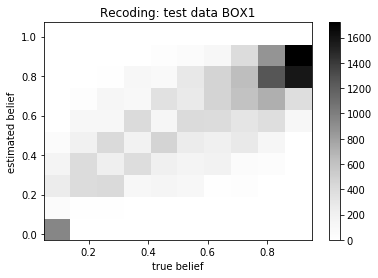

In [12]:
# plot: compare raw data vs prediction
plt.hist2d(y_test[:,0]/10, predic_X_test[:,0]/10, bins=(10, 10), cmap=plt.cm.Greys)
plt.colorbar()
plt.xlabel('true belief')
plt.ylabel('estimated belief')
plt.title('Recoding: test data BOX1')
plt.savefig('./figures/recoding_KRR_box1.eps', format = 'eps')


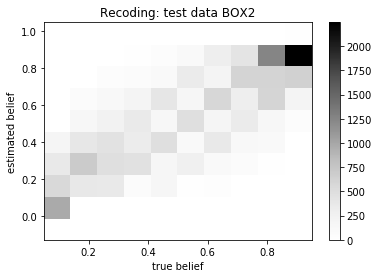

In [13]:
# plot: compare raw data vs prediction
#plt.scatter(a_df_test, a_dec_test, s=0.005, c='blue', marker='o')
plt.hist2d(y_test[:,1]/10, predic_X_test[:,1]/10, bins=(10, 10), cmap=plt.cm.Greys)
plt.colorbar()
plt.xlabel('true belief')
plt.ylabel('estimated belief')
plt.title('Recoding: test data BOX2')
plt.savefig('./figures/recoding_KRR_box2.eps', format = 'eps')


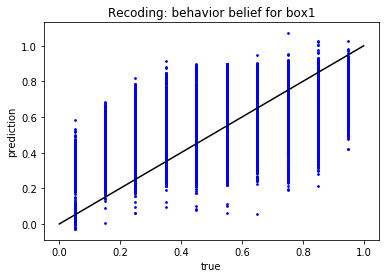

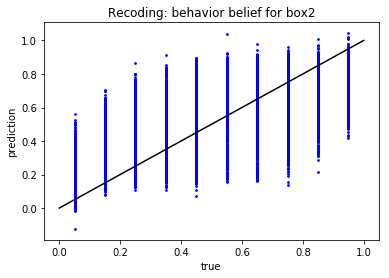

In [14]:
line_x = np.linspace(0,1,num=11)
line_y = np.linspace(0,1,num=11)


# plot: compare raw data vs prediction
plt.scatter(y_test[:,0]/10, predic_X_test[:,0]/10, s=3, c='blue', marker='o')
plt.plot(line_x, line_y,c='k')
plt.xlabel('true')
plt.ylabel('prediction')
plt.title('Recoding: behavior belief for box1')
plt.show()

plt.scatter(y_test[:,1]/10, predic_X_test[:,1]/10, s=3, c='blue', marker='o')
plt.plot(line_x, line_y,c='k')
plt.xlabel('true')
plt.ylabel('prediction')
plt.title('Recoding: behavior belief for box2')
plt.show()

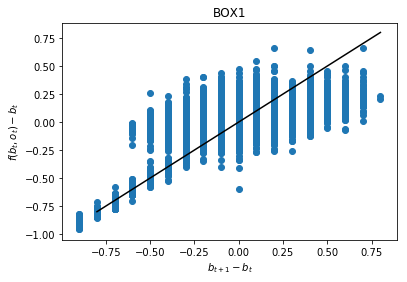

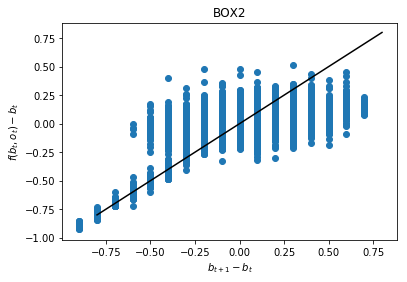

In [15]:
# plot changes
line_x = np.linspace(-.8,.8,num=11)
line_y = np.linspace(-.8,.8,num=11)

true_change = (y - X[:,:2])/10
predic_X = regr.predict(X) # all data
predicted_change = (predic_X - X[:,:2])/10

plt.scatter(true_change[:,0], predicted_change[:,0])
plt.plot(line_x, line_y,c='k')
plt.xlabel('$b_{t+1}-b_t$')
plt.ylabel('$f(b_t, o_t)-b_t$')
plt.title('BOX1')
plt.savefig('./figures/recoding_DELTA_KRR_box1.eps', format = 'eps')


plt.figure()
plt.scatter(true_change[:,1], predicted_change[:,1])
plt.xlabel('$b_{t+1}-b_t$')
plt.ylabel('$f(b_t, o_t)-b_t$')
plt.plot(line_x, line_y,c='k')
plt.title('BOX2')
plt.savefig('./figures/recoding_DELTA_KRR_box2.eps', format = 'eps')